In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [ ]:
%%capture
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

In [ ]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name):
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"


# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

In [ ]:
sample_lengths = []
folder_path = '/content/drive/MyDrive/Audio_Song_Actors_01-24 (1)'

# Limit the number of files to process for testing (e.g., first 10 files)
for subdir, dirs, files in os.walk(folder_path):
    for file in files[:10]:  # Process the first 10 files
        x, sr = librosa.load(path=os.path.join(subdir, file), sr=None)
        xt, index = librosa.effects.trim(x, top_db=30)

        sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))


Maximum sample length: 214528


In [ ]:
# Maximum samples count for padding purposes.

sample_lengths = []
folder_path = '/content/drive/My Drive/AudioFiles'

for subdir, dirs, files in os.walk(folder_path):
  for file in files:
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)

    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))

Maximum sample length: 173056


In [ ]:
import time
tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 214528  # Desired frame length for all audio samples.
frame_length = 2048
hop_length = 512

folder_path = '/content/drive/MyDrive/Audio_Song_Actors_01-24 (1)'

for subdir, dirs, files in os.walk(folder_path):
    for file in files:
        # Fetch the sample rate.
        _, sr = librosa.load(path=os.path.join(subdir, file), sr=None)  # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
        # Load the audio file.
        rawsound = AudioSegment.from_file(os.path.join(subdir, file))
        # Normalize the audio to +5.0 dBFS.
        normalizedsound = effects.normalize(rawsound, headroom=0)
        # Transform the normalized audio to np.array of samples.
        normal_x = np.array(normalizedsound.get_array_of_samples(), dtype='float32')
        # Trim silence from the beginning and the end.
        xt, index = librosa.effects.trim(normal_x, top_db=30)

        # Check if total_length exceeds the length of the trimmed audio
        if total_length >= len(xt):
            # Pad for duration equalization.
            padded_x = np.pad(xt, (0, total_length - len(xt)), 'constant')
        else:
            padded_x = xt  # No padding if total_length is smaller

        # Noise reduction.
        final_x = nr.reduce_noise(y=padded_x, sr=sr)  # Updated 03/03/22

        # Features extraction
        f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length)  # Energy - Root Mean Square
        f2 = librosa.feature.zero_crossing_rate(y=final_x, frame_length=frame_length, hop_length=hop_length, center=True)  # ZCR
        f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length=hop_length)  # MFCC

        # Emotion extraction from the different databases
        if (find_emotion_T(file) != "-1"):  # TESS database validation
            name = find_emotion_T(file)
        else:  # RAVDESS database validation
            name = file[6:8]

        # Filling the data lists
        rms.append(f1)
        zcr.append(f2)
        mfcc.append(f3)
        emotions.append(emotionfix(name))

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")


Running time: 8.0875 minutes


In [ ]:
import time
tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 173056 # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = '/content/drive/My Drive/AudioFiles'

for subdir, dirs, files in os.walk(folder_path):
  for file in files:

    # Fetch the sample rate.
      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file))
    # Normalize the audio to +5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 0)
    # Transform the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)
      #print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed--
    # Pad for duration equalization.
      padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')
    # Noise reduction.
      final_x = nr.reduce_noise(padded_x, sr=sr) #updated 03/03/22

   # Features extraction
      f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
      f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR
      f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC

   # Emotion extraction from the different databases
      if (find_emotion_T(file) != "-1"): #TESS database validation
            name = find_emotion_T(file)
      else:                              #RAVDESS database validation
            name = file[6:8]

   # Filling the data lists
      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      emotions.append(emotionfix(name))

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

Running time: 12.7427 minutes


In [ ]:
# Initialize lists for RMS, ZCR, and MFCCs
rms = []
zcr = []
mfcc = []

# Initialize variables
total_length = 214528  # Desired frame length for all audio samples.
frame_length = 2048
hop_length = 512

folder_path = '/content/drive/MyDrive/Audio_Song_Actors_01-24 (1)'

for subdir, dirs, files in os.walk(folder_path):
    for file in files:
        # ... (previous code to load and process audio) ...

        # Pad or truncate the features to have a consistent shape
        max_features_length = 100  # Adjust as needed
        if f1.shape[1] < max_features_length:
            f1 = np.pad(f1, ((0, 0), (0, max_features_length - f1.shape[1])), mode='constant')
        else:
            f1 = f1[:, :max_features_length]

        if f2.shape[1] < max_features_length:
            f2 = np.pad(f2, ((0, 0), (0, max_features_length - f2.shape[1])), mode='constant')
        else:
            f2 = f2[:, :max_features_length]

        if f3.shape[1] < max_features_length:
            f3 = np.pad(f3, ((0, 0), (0, max_features_length - f3.shape[1])), mode='constant')
        else:
            f3 = f3[:, :max_features_length]

        # Append the features to the respective lists
        rms.append(f1)
        zcr.append(f2)
        mfcc.append(f3)

# Now, you can convert the lists to NumPy arrays
f_rms = np.asarray(rms).astype('float32')
f_zcr = np.asarray(zcr).astype('float32')
f_mfccs = np.asarray(mfcc).astype('float32')

# Adjust the shape
f_rms = np.swapaxes(f_rms, 1, 2)
f_zcr = np.swapaxes(f_zcr, 1, 2)
f_mfccs = np.swapaxes(f_mfccs, 1, 2)

print('ZCR shape:', f_zcr.shape)
print('RMS shape:', f_rms.shape)
print('MFCCs shape:', f_mfccs.shape)


ZCR shape: (1012, 100, 1)
RMS shape: (1012, 100, 1)
MFCCs shape: (1012, 100, 13)


In [ ]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (4232, 339, 1)
RMS shape: (4232, 339, 1)
MFCCs shape: (4232, 339, 13)


In [ ]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [ ]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [ ]:
# Save X,Y arrays as lists to json files.

x_data = X.tolist()
x_path = '/content/drive/My Drive/Colab Notebooks/X_datanew.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist()
y_path = '/content/drive/My Drive/Colab Notebooks/Y_datanew.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)


'[[0], [1], [0], [1], [1], [2], [1], [0], [1], [3], [2], [3], [1], [2], [1], [1], [2], [0], [2], [2], [3], [2], [2], [3], [3], [3], [5], [5], [3], [5], [3], [4], [4], [5], [5], [4], [4], [4], [5], [5], [4], [4], [5], [4], [0], [2], [2], [0], [1], [2], [1], [1], [1], [0], [3], [1], [1], [2], [2], [0], [1], [1], [2], [3], [2], [3], [2], [4], [4], [3], [5], [3], [5], [4], [5], [4], [5], [4], [3], [5], [5], [4], [4], [5], [3], [4], [3], [5], [1], [0], [0], [1], [1], [0], [0], [1], [2], [2], [3], [1], [3], [2], [2], [3], [1], [2], [3], [3], [3], [2], [1], [1], [3], [3], [2], [2], [5], [4], [5], [4], [4], [5], [4], [4], [5], [5], [4], [5], [5], [5], [4], [4], [0], [1], [1], [2], [1], [1], [0], [0], [3], [2], [1], [2], [1], [1], [2], [2], [0], [2], [2], [1], [2], [3], [3], [4], [5], [4], [5], [3], [4], [4], [5], [4], [4], [5], [5], [4], [3], [5], [3], [5], [4], [5], [3], [3], [1], [0], [1], [1], [1], [1], [0], [1], [0], [0], [1], [2], [2], [4], [3], [3], [2], [1], [3], [4], [4], [2], [3], [3]

In [ ]:
# Load X,Y json files back into lists, convert to np.arrays

x_path = '/content/drive/My Drive/Colab Notebooks/X_datanew.json' # FILE LOAD PATH
X = load(x_path)
X = np.asarray(X, dtype = 'float32')

y_path = '/content/drive/My Drive/Colab Notebooks/Y_datanew.json' # FILE LOAD PATH
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

In [ ]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8, dtype = 'int8')

In [ ]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(885, 100, 15)
(88, 100, 15)
(39, 100, 15)


In [ ]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(3703, 339, 15)
(368, 339, 15)
(161, 339, 15)


In [ ]:
# Save x_test, y_test to JSON.

file_path = 'x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[1], [4], [2], [4], [5], [4], [3], [1], [5], [0], [4], [5], [3], [2], [0], [1], [2], [0], [3], [3], [0], [0], [2], [1], [5], [0], [4], [3], [1], [3], [3], [4], [4], [0], [4], [3], [1], [0], [1]], "dtype": "int8", "shape": [39, 1], "Corder": true}'

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks

In [ ]:
# Initializing the model

model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',
                                    factor=0.1, patience=100)

# Compile & train
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class,
                      epochs=340, batch_size = batch_size,
                      validation_data = (x_val, y_val_class),
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 54024 (211.03 KB)
Trainable params: 54024 (211.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/340
39/39 [==============================] - 6s 95ms/step - loss: 1.8569 - categorical_accuracy: 0.1379 - val_loss: 1.7624 - val_categorical_accuracy: 0.2841 - lr: 0.0010
Epoch 2/340
 2/39 [>.............................] - ETA: 2s - loss: 1.7842 - categorical_accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 3s 66ms/step - loss: 1.7819 - categorical_accuracy: 0.2169 - val_loss: 1.7820 - val_categorical_accuracy: 0.2273 - lr: 0.0010
Epoch 3/340
39/39 [==============================] - 3s 67ms/step - loss: 1.7905 - categorical_accuracy: 0.1740 - val_loss: 1.7794 - val_categorical_accuracy: 0.1023 - lr: 0.0010
Epoch 4/340
39/39 [==============================] - 3s 65ms/step - loss: 1.7815 - categorical_accuracy: 0.1898 - val_loss: 1.8109 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 5/340
39/39 [==============================] - 3s 79ms/step - loss: 1.7737 - categorical_accuracy: 0.1751 - val_loss: 1.7548 - val_categorical_accuracy: 0.2273 - lr: 0.0010
Epoch 6/340
39/39 [==============================] - 3s 71ms/step - loss: 1.7778 - categorical_accuracy: 0.1706 - val_loss: 1.7652 - val_categorical_accuracy: 0.1818 - lr: 0.0010
Epoch 7/340
39/39 [==============================] - 3s 67ms/step - loss: 1.7745 - categorical_accuracy: 0.1774 - val

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

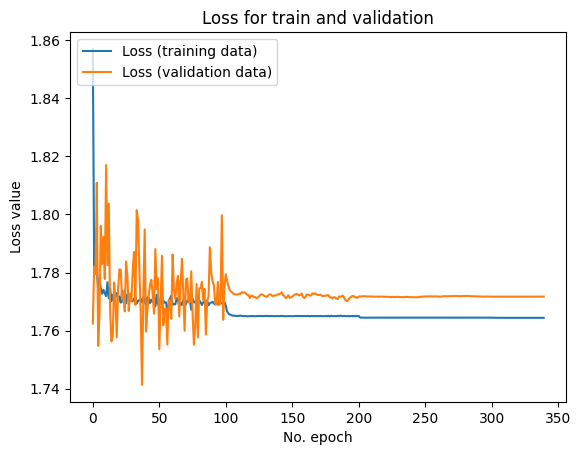

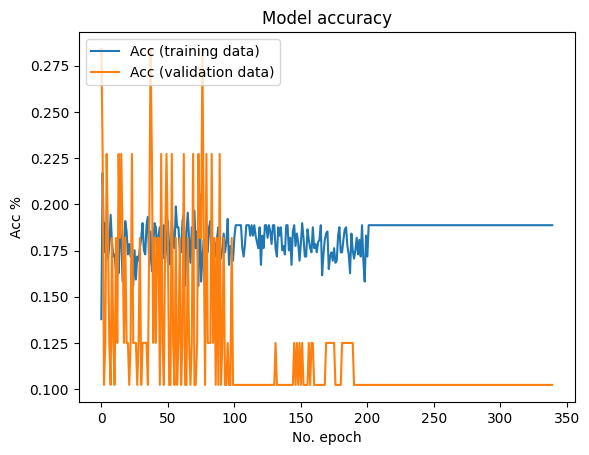

In [ ]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

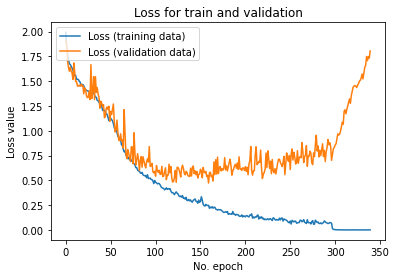

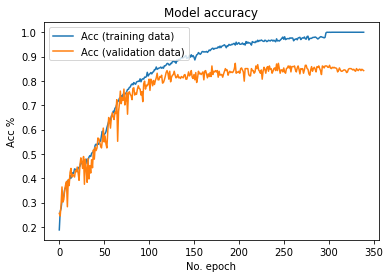

In [ ]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

**Val Set Score**

In [ ]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

3/3 - 0s - loss: 1.7624 - categorical_accuracy: 0.2841 - 66ms/epoch - 22ms/step


In [ ]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

12/12 - 2s - loss: 0.5993 - categorical_accuracy: 0.8723


**Val Set Confussion Matrix**

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already defined your confusion matrix 'cm'

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=index, columns=columns)

# Create a heatmap for visualization
plt.figure(figsize=(12, 8))
ax = plt.axes()
sns.heatmap(cm_df, ax=ax, cmap='PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')
plt.show()


ValueError: ignored

Text(0.5, 51.0, 'Predicted emotion')

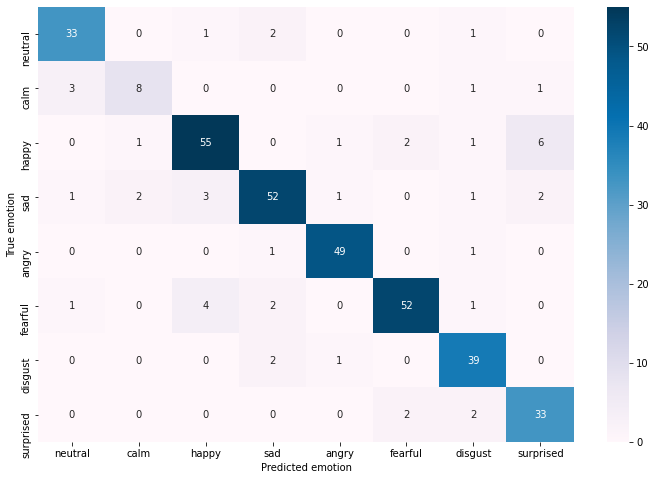

In [ ]:
# Validation Confusion matrix

y_val_class = np.argmax(y_val_class, axis=1)
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

**Validation Set Predicted emotions accuracy**

In [ ]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.0000
calm : nan


<ipython-input-34-42ae9e950c21>:5: RuntimeWarning: invalid value encountered in divide
  acc = values / row_sum


In [ ]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.8919
calm : 0.6154
happy : 0.8333
sad : 0.8387
angry : 0.9608
fearful : 0.8667
disgust : 0.9286
surprised : 0.8919


## **Save & Load model, weights**


In [ ]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)

model.save_weights(saved_weights_path)
print("Saved model to disk")


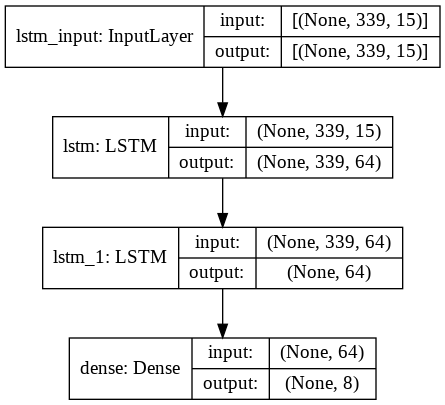

In [ ]:
# Reading the model from JSON file

saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load( 'x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, 8, dtype = 'int8')

## **Test Set Evaluation**

**Test Set Score**

In [ ]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

6/6 - 1s - loss: 0.5561 - categorical_accuracy: 0.8447


**Test Set Confussion Matrix**

Text(0.5, 51.0, 'Predicted emotion')

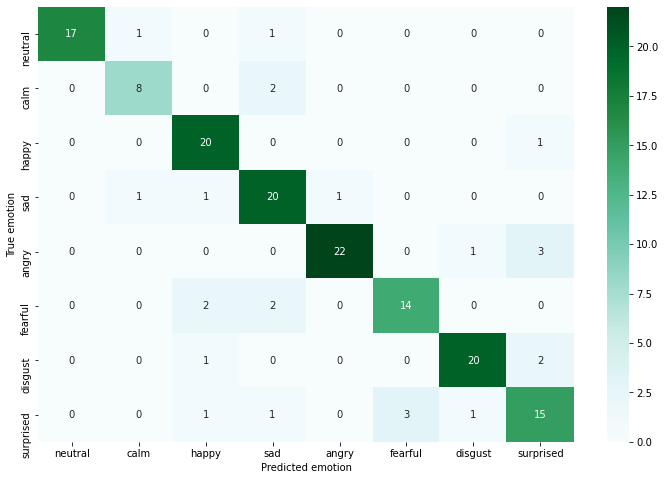

In [ ]:
# Test set Confusion matrix

y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

**Test Set Predicted emotions accuracy**

In [ ]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 0.8947
calm : 0.8000
happy : 0.9524
sad : 0.8696
angry : 0.8462
fearful : 0.7778
disgust : 0.8696
surprised : 0.7143


# **RESULTS & CONCLUSIONS**
As seen, the validation set accuracy of the model had come up to 87.23% and the test set accuracy had reached 84.47% with overfitting in the training process starting around the 100th epoch. Although various regulations have been placed in earlier tryouts, they had restricted the accuracy from reaching its maximum value. A ModelCheckpoint is applied, saving the best weights according to the model's accuracy, thus the overfitting is bypassed.

Within the next part of the study in which the model will be used as a Real-time SER, The inputs will be processed similarly as the data used by the model, to gain similarity and therefore, precision.